In [1]:
import datetime
import math
import os
from datetime import datetime, timedelta
from math import sqrt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly as py
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import requests
import seaborn as sns
import statsmodels.api as sm
from dateutil.easter import easter
from numpy.random import normal, seed
from pandas.plotting import autocorrelation_plot
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
from plotly.subplots import make_subplots
from prophet import Prophet

%matplotlib inline
from pylab import rcParams
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller

rcParams["figure.figsize"] = 20, 20


# for tsa
import statsmodels.api as sm

## import written functions
from acquire import get_stores
from prepare import clean_store

# to evaluated performance using rmse
# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error

# holt's linear trend model.
# holt's linear trend model.
from statsmodels.tsa.api import Holt

plt.style.use("bmh")

# Exercise: Modeling

## The end result of this exercise should be a Jupyter notebook named model.

### Using saas.csv or log data from API usage or store_item_sales

### Split data (train/validate/test) and resample by any period, except daily, and aggregate using the sum.Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:

- Simple Average
- Moving Average
- Holt's Linear Trend 
- Model Based on previous year/month/etc.... 


----
### This is not required due to Adams guidance, so i will still go through the steps just with my TESLA data for my individual time series project !!! 
----

In [2]:
Tesla = pd.read_csv("TSLA.csv", index_col="Date", parse_dates=["Date"])

In [3]:
Tesla.head()

Open   High    Low  Close  Adj Close    Volume
Date                                                       
2018-03-23 311.25 311.25 300.45 301.54     301.54   6654900
2018-03-26 307.34 307.59 291.36 304.18     304.18   8375200
2018-03-27 304.00 304.27 277.18 279.18     279.18  13872000
2018-03-28 264.58 268.68 252.10 257.78     257.78  21001400
2018-03-29 256.49 270.96 248.21 266.13     266.13  15170700

In [4]:
Tesla.drop("Adj Close", axis=1, inplace=True)

In [5]:
Tesla["Name"] = "TSLA"

In [6]:
Tesla = Tesla.rename(
    columns={
        "Date": "date",
        "Open": "open",
        "High": "high",
        "Low": "low",
        "Close": "close",
        "Volume": "volume",
    }
)
Tesla.head()

open   high    low  close    volume  Name
Date                                                  
2018-03-23 311.25 311.25 300.45 301.54   6654900  TSLA
2018-03-26 307.34 307.59 291.36 304.18   8375200  TSLA
2018-03-27 304.00 304.27 277.18 279.18  13872000  TSLA
2018-03-28 264.58 268.68 252.10 257.78  21001400  TSLA
2018-03-29 256.49 270.96 248.21 266.13  15170700  TSLA

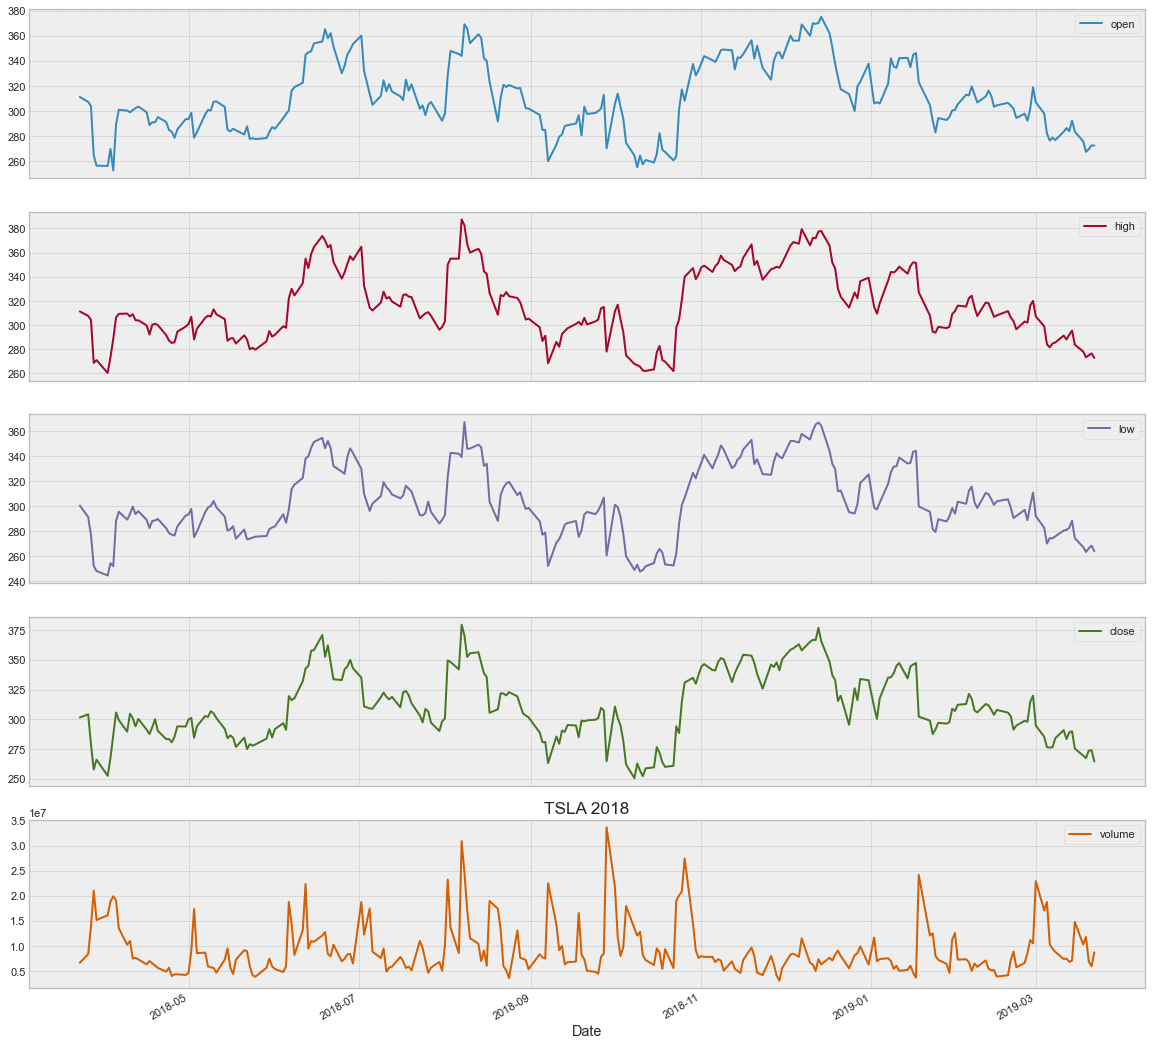

In [7]:
Tesla.plot(subplots=True, figsize=(20, 20))
plt.title("TSLA 2018")
plt.show()

---
# For my own help ..... 
- Timestamps 
- Periods 

In [8]:
# Time stamps

timestamp = pd.Timestamp(2018, 4, 1, 12)
timestamp

Timestamp('2018-04-01 12:00:00')

In [9]:
# Creating a period
period = pd.Period("2018-04-01")
period

Period('2018-04-01', 'D')

In [10]:
# Checking if the given timestamp exists in the given period
period.start_time < timestamp < period.end_time

True

In [11]:
# Converting timestamp to period
new_period = timestamp.to_period(freq="H")
new_period

Period('2018-04-01 12:00', 'H')

In [12]:
# Converting period to timestamp
new_timestamp = period.to_timestamp(freq="H", how="start")
new_timestamp

Timestamp('2018-04-01 00:00:00')

# Using the date-range functions once again this is for my own help ...... 

In [13]:
# Creating a datetimeindex with daily frequency
dr1 = pd.date_range(start="3/23/18", end="3/22/19")
dr1

DatetimeIndex(['2018-03-23', '2018-03-24', '2018-03-25', '2018-03-26',
               '2018-03-27', '2018-03-28', '2018-03-29', '2018-03-30',
               '2018-03-31', '2018-04-01',
               ...
               '2019-03-13', '2019-03-14', '2019-03-15', '2019-03-16',
               '2019-03-17', '2019-03-18', '2019-03-19', '2019-03-20',
               '2019-03-21', '2019-03-22'],
              dtype='datetime64[ns]', length=365, freq='D')

In [14]:
# Creating a datetimeindex with monthly frequency
dr2 = pd.date_range(start="3/23/18", end="3/22/19", freq="M")
dr2

DatetimeIndex(['2018-03-31', '2018-04-30', '2018-05-31', '2018-06-30',
               '2018-07-31', '2018-08-31', '2018-09-30', '2018-10-31',
               '2018-11-30', '2018-12-31', '2019-01-31', '2019-02-28'],
              dtype='datetime64[ns]', freq='M')

In [15]:
# Creating a datetimeindex without specifying start date and using periods
dr3 = pd.date_range(end="6/4/2018", periods=8)
dr3

DatetimeIndex(['2018-05-28', '2018-05-29', '2018-05-30', '2018-05-31',
               '2018-06-01', '2018-06-02', '2018-06-03', '2018-06-04'],
              dtype='datetime64[ns]', freq='D')

In [16]:
dr4 = pd.date_range(start="2018-11-24", end="2019-11-27", periods=3)
dr4

DatetimeIndex(['2018-11-24', '2019-05-27', '2019-11-27'], dtype='datetime64[ns]', freq=None)

# Forward fill and back fill 


In [17]:
Tesla.head()

open   high    low  close    volume  Name
Date                                                  
2018-03-23 311.25 311.25 300.45 301.54   6654900  TSLA
2018-03-26 307.34 307.59 291.36 304.18   8375200  TSLA
2018-03-27 304.00 304.27 277.18 279.18  13872000  TSLA
2018-03-28 264.58 268.68 252.10 257.78  21001400  TSLA
2018-03-29 256.49 270.96 248.21 266.13  15170700  TSLA

In [18]:
Tesla = Tesla.iloc[1:]
Tesla = Tesla.fillna(method="ffill")
Tesla.head()

open   high    low  close    volume  Name
Date                                                  
2018-03-26 307.34 307.59 291.36 304.18   8375200  TSLA
2018-03-27 304.00 304.27 277.18 279.18  13872000  TSLA
2018-03-28 264.58 268.68 252.10 257.78  21001400  TSLA
2018-03-29 256.49 270.96 248.21 266.13  15170700  TSLA
2018-04-02 256.26 260.33 244.59 252.48  16114000  TSLA

In [19]:
Tesla = Tesla.fillna(method="bfill")
Tesla.head()

open   high    low  close    volume  Name
Date                                                  
2018-03-26 307.34 307.59 291.36 304.18   8375200  TSLA
2018-03-27 304.00 304.27 277.18 279.18  13872000  TSLA
2018-03-28 264.58 268.68 252.10 257.78  21001400  TSLA
2018-03-29 256.49 270.96 248.21 266.13  15170700  TSLA
2018-04-02 256.26 260.33 244.59 252.48  16114000  TSLA

In [20]:
# Shape before resampling(downsampling)
Tesla.shape

(250, 6)

In [21]:
Tesla_resampled = Tesla.resample(
    "3D"
).mean()  # We downsample from hourly to 3 day frequency aggregated using mean
Tesla_resampled.head()

open   high    low  close      volume
Date                                              
2018-03-26 291.97 293.51 273.55 280.38 14416200.00
2018-03-29 256.49 270.96 248.21 266.13 15170700.00
2018-04-01 263.04 266.84 249.54 260.00 17479200.00
2018-04-04 281.04 301.30 278.57 297.32 17512700.00
2018-04-07 300.37 309.50 289.21 289.66 10249800.00

In [22]:
Tesla_resampled.shape

(121, 5)

In [23]:
Tesla_resampled = Tesla.resample("D").pad()
Tesla_resampled.head()

open   high    low  close    volume  Name
Date                                                  
2018-03-26 307.34 307.59 291.36 304.18   8375200  TSLA
2018-03-27 304.00 304.27 277.18 279.18  13872000  TSLA
2018-03-28 264.58 268.68 252.10 257.78  21001400  TSLA
2018-03-29 256.49 270.96 248.21 266.13  15170700  TSLA
2018-03-30 256.49 270.96 248.21 266.13  15170700  TSLA

In [24]:
Tesla_resampled.shape

(362, 6)

_____


# Finance Information that we can use................... and Stats 
- Percent change
- Stock returns
- Absolute change in successive rows
- Window functions
- OHLC charts
- Candlestick charts
- Autocorrelation and Partial Autocorrelation¶

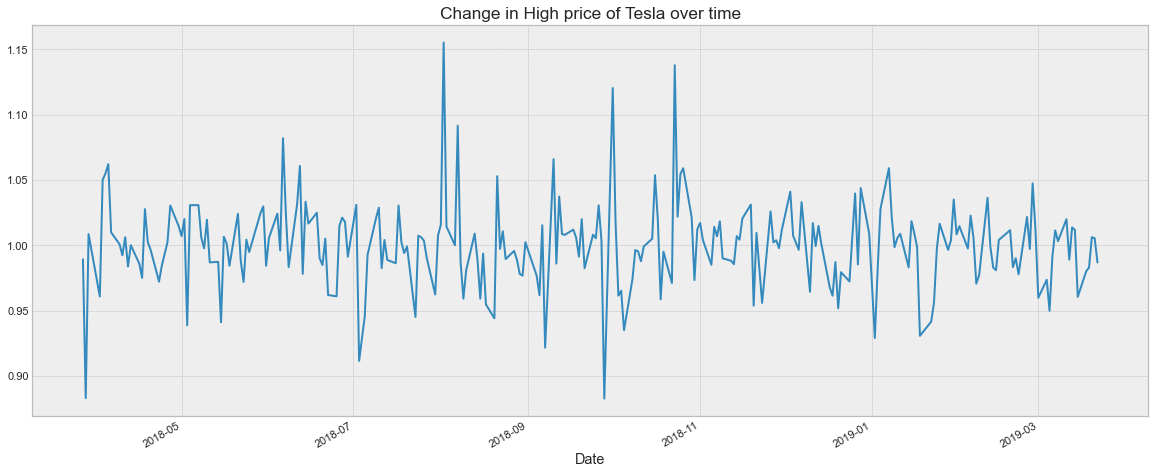

In [25]:
Tesla["Change"] = Tesla.high.div(Tesla.high.shift())
Tesla["Change"].plot(figsize=(20, 8))
_ = plt.title("Change in High price of Tesla over time")

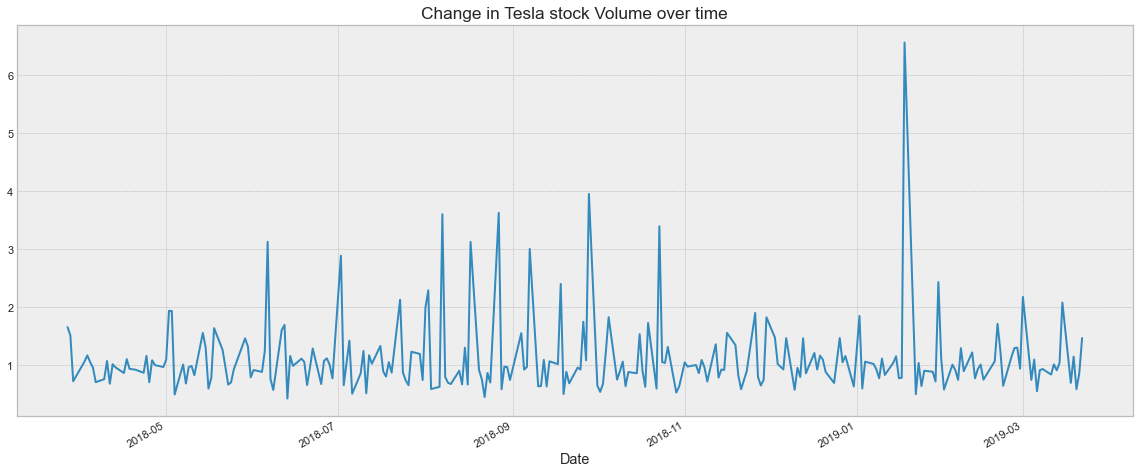

In [26]:
Tesla["Volume_Change"] = Tesla.volume.div(Tesla.volume.shift())
Tesla["Volume_Change"].plot(figsize=(20, 8))
_ = plt.title("Change in Tesla stock Volume over time")

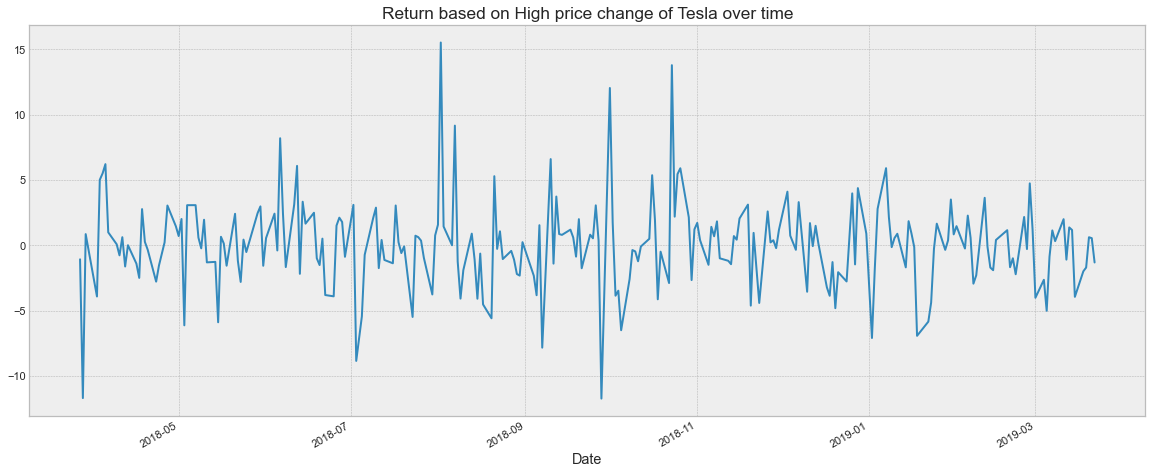

In [27]:
Tesla["Return"] = Tesla.Change.sub(1).mul(100)
Tesla["Return"].plot(figsize=(20, 8))
_ = plt.title("Return based on High price change of Tesla over time")

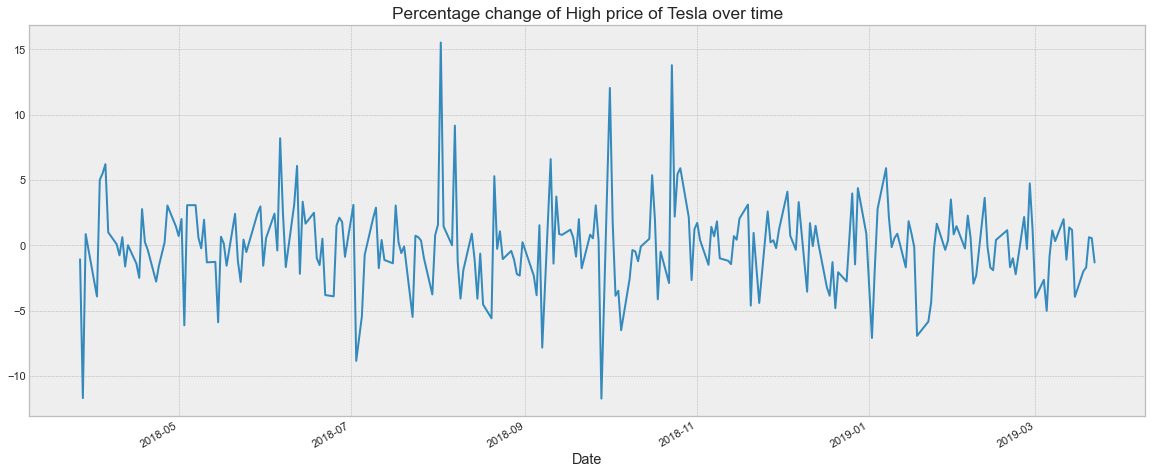

In [28]:
Tesla.high.pct_change().mul(100).plot(
    figsize=(20, 8)
)  # Another way to calculate returns in %
_ = plt.title("Percentage change of High price of Tesla over time")

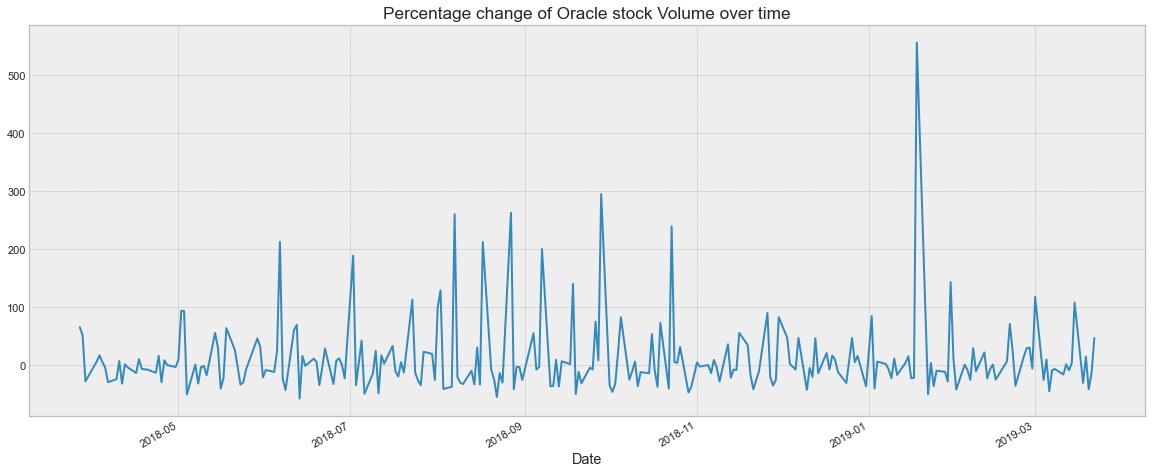

In [29]:
Tesla.volume.pct_change().mul(100).plot(
    figsize=(20, 8)
)  # Another way to calculate returns in %
_ = plt.title("Percentage change of Oracle stock Volume over time")

## Absolute change in successive rows

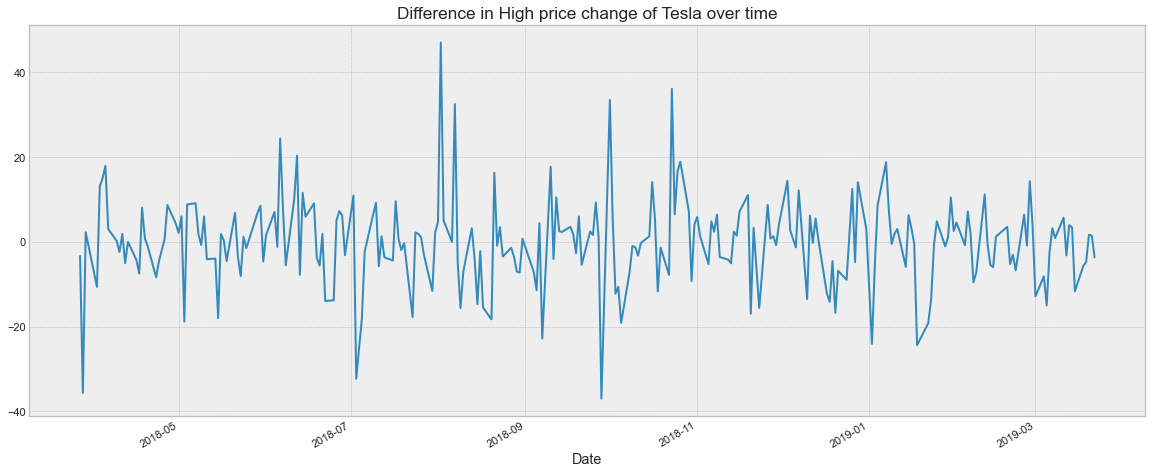

In [30]:
Tesla.high.diff().plot(figsize=(20, 8))
_ = plt.title("Difference in High price change of Tesla over time")

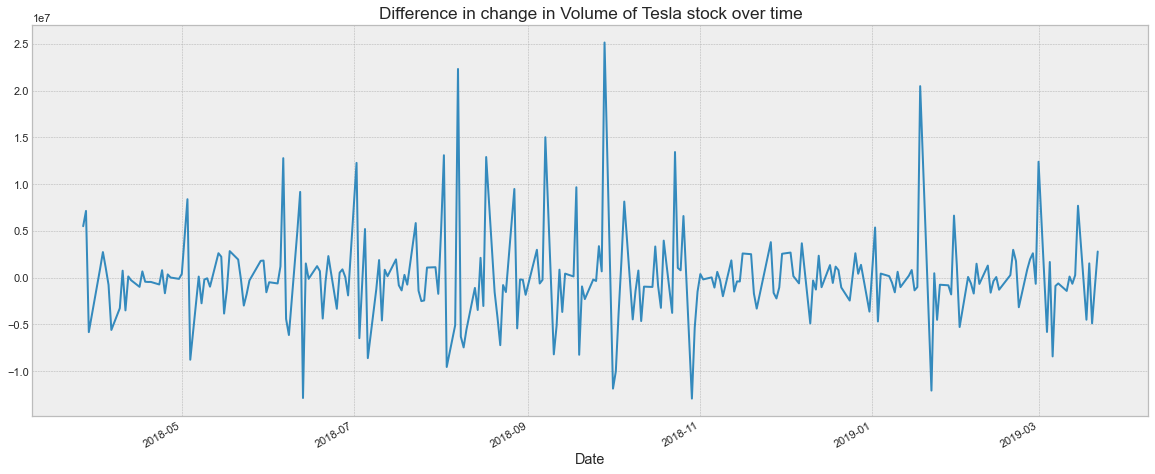

In [31]:
Tesla.volume.diff().plot(figsize=(20, 8))
_ = plt.title("Difference in change in Volume of Tesla stock over time")

#  Window functions
- Rolling - Same size and sliding

- Expanding - Contains all prior values

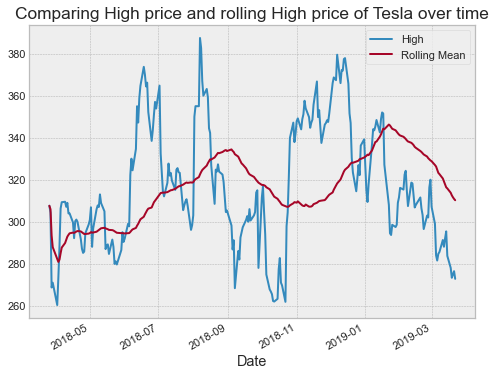

In [32]:
rolling_Tesla = Tesla.high.rolling("90D").mean()
Tesla.high.plot()
rolling_Tesla.plot()
_ = plt.title("Comparing High price and rolling High price of Tesla over time")
plt.legend(["High", "Rolling Mean"])

# Plotting a rolling mean of 90 day window with original High attribute of Tesla stocks
plt.show()

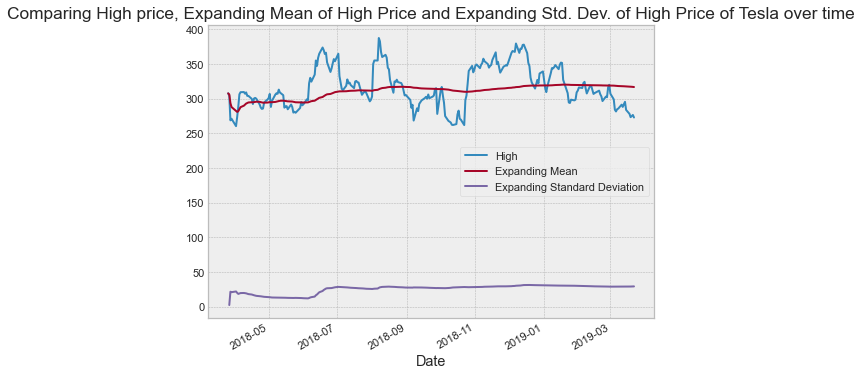

In [33]:
# Expanding window functions
Tesla_mean = Tesla.high.expanding().mean()
Tesla_std = Tesla.high.expanding().std()
Tesla.high.plot()
Tesla_mean.plot()
Tesla_std.plot()
_ = plt.title(
    "Comparing High price, Expanding Mean of High Price and Expanding Std. Dev. of High Price of Tesla over time"
)
plt.legend(["High", "Expanding Mean", "Expanding Standard Deviation"])
plt.show()

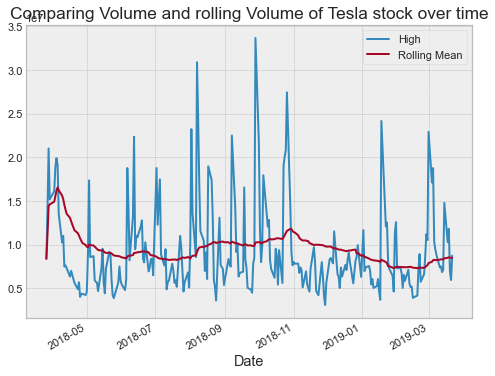

In [34]:
# Rolling window functions
rolling_Tesla = Tesla.volume.rolling("90D").mean()
Tesla.volume.plot()
rolling_Tesla.plot()
_ = plt.title("Comparing Volume and rolling Volume of Tesla stock over time")
plt.legend(["High", "Rolling Mean"])
# Plotting a rolling mean of 90 day window with original High attribute of Tesla stocks
plt.show()

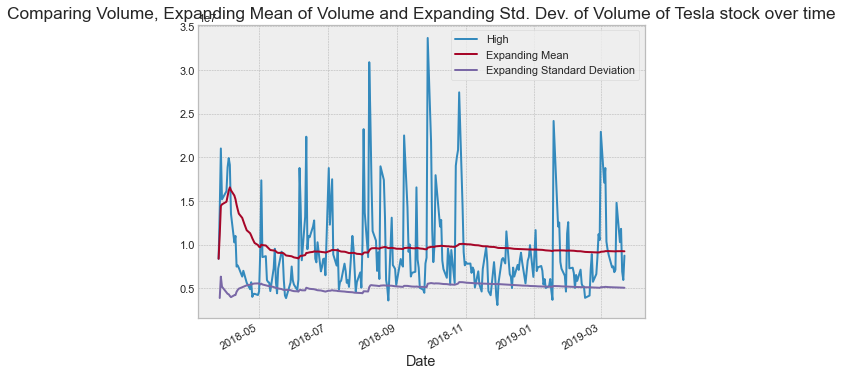

In [35]:
Tesla_mean = Tesla.volume.expanding().mean()
Tesla_std = Tesla.volume.expanding().std()
Tesla.volume.plot()
Tesla_mean.plot()
Tesla_std.plot()
_ = plt.title(
    "Comparing Volume, Expanding Mean of Volume and Expanding Std. Dev. of Volume of Tesla stock over time"
)
plt.legend(["High", "Expanding Mean", "Expanding Standard Deviation"])
plt.show()

# OHLC charts

An OHLC chart is any type of price chart that shows the open, high, low and close price of a certain time period. Open-high-low-close Charts (or OHLC Charts) are used as a trading tool to visualise and analyse the price changes over time for securities, currencies, stocks, bonds, commodities, etc. OHLC Charts are useful for interpreting the day-to-day sentiment of the market and forecasting any future price changes through the patterns produced.

The y-axis on an OHLC Chart is used for the price scale, while the x-axis is the timescale. On each single time period, an OHLC Charts plots a symbol that represents two ranges: the highest and lowest prices traded, and also the opening and closing price on that single time period (for example in a day). On the range symbol, the high and low price ranges are represented by the length of the main vertical line. The open and close prices are represented by the vertical positioning of tick-marks that appear on the left (representing the open price) and on right (representing the close price) sides of the high-low vertical line.

Color can be assigned to each OHLC Chart symbol, to distinguish whether the market is "bullish" (the closing price is higher then it opened) or "bearish" (the closing price is lower then it opened).

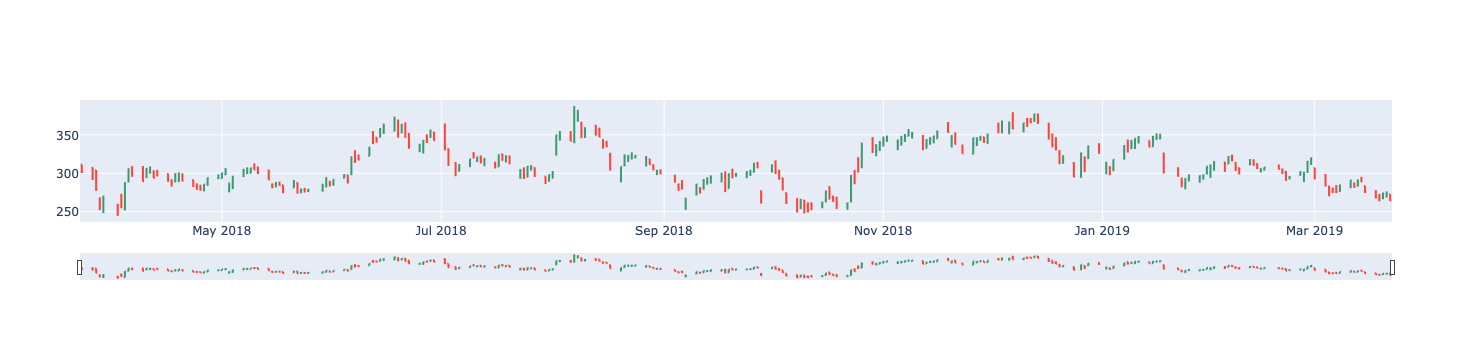

In [36]:
# OHLC chart of June 2018

df = pd.read_csv("TSLA.csv")


fig = go.Figure(
    data=go.Ohlc(
        x=df["Date"], open=df["Open"], high=df["High"], low=df["Low"], close=df["Close"]
    )
)
fig.show()

# Candlestick charts

This type of chart is used as a trading tool to visualize and analyze the price movements over time for securities, derivatives, currencies, stocks, bonds, commodities, etc. Although the symbols used in Candlestick Charts resemble a Box Plot, they function differently and therefore, are not to be confused with one another.

Candlestick Charts display multiple bits of price information such as the open price, close price, highest price and lowest price through the use of candlestick-like symbols. Each symbol represents the compressed trading activity for a single time period (a minute, hour, day, month, etc). Each Candlestick symbol is plotted along a time scale on the x-axis, to show the trading activity over time.

The main rectangle in the symbol is known as the real body, which is used to display the range between the open and close price of that time period. While the lines extending from the bottom and top of the real body is known as the lower and upper shadows (or wick). Each shadow represents the highest or lowest price traded during the time period represented. When the market is Bullish (the closing price is higher than it opened), then the body is colored typically white or green. But when the market is Bearish (the closing price is lower than it opened), then the body is usually colored either black or red.

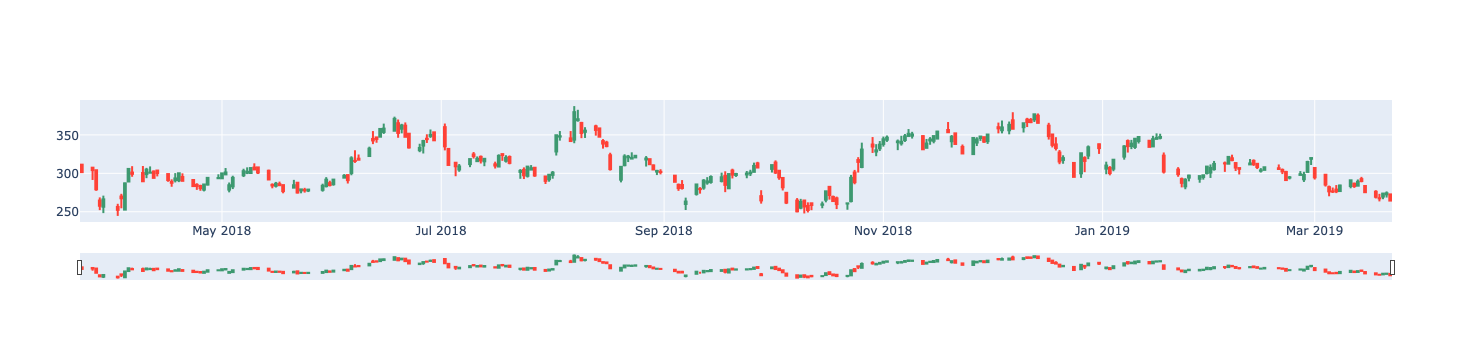

In [37]:
df = pd.read_csv("TSLA.csv")

fig = go.Figure(
    data=[
        go.Candlestick(
            x=df["Date"],
            open=df["Open"],
            high=df["High"],
            low=df["Low"],
            close=df["Close"],
        )
    ]
)

fig.show()

# Autocorrelation and Partial Autocorrelation
 - Autocorrelation - The autocorrelation function (ACF) measures how a series is correlated with itself at different lags.
- Partial Autocorrelation - The partial autocorrelation function can be interpreted as a regression of the series against its past lags. The terms can be interpreted the same way as a standard linear regression, that is the contribution of a change in that particular lag while holding others constant.


In [17]:
import itertools
import warnings
from random import gauss, random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pandas.plotting import autocorrelation_plot
from prophet.plot import add_changepoints_to_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

plt.style.use("bmh")
# import matplotlib as mpl
import seaborn as sns

plt.rcParams["figure.figsize"] = (15, 15)

In [42]:
Tesla.head()

open   high    low  close    volume  Name  Change  Volume_Change  \
Date                                                                            
2018-03-26 307.34 307.59 291.36 304.18   8375200  TSLA     NaN            NaN   
2018-03-27 304.00 304.27 277.18 279.18  13872000  TSLA    0.99           1.66   
2018-03-28 264.58 268.68 252.10 257.78  21001400  TSLA    0.88           1.51   
2018-03-29 256.49 270.96 248.21 266.13  15170700  TSLA    1.01           0.72   
2018-04-02 256.26 260.33 244.59 252.48  16114000  TSLA    0.96           1.06   

            Return  
Date                
2018-03-26     NaN  
2018-03-27   -1.08  
2018-03-28  -11.70  
2018-03-29    0.85  
2018-04-02   -3.92

In [39]:
help(seasonal_decompose)

Help on function seasonal_decompose in module statsmodels.tsa.seasonal:

seasonal_decompose(x, model='additive', filt=None, period=None, two_sided=True, extrapolate_trend=0)
    Seasonal decomposition using moving averages.
    
    Parameters
    ----------
    x : array_like
        Time series. If 2d, individual series are in columns. x must contain 2
        complete cycles.
    model : {"additive", "multiplicative"}, optional
        Type of seasonal component. Abbreviations are accepted.
    filt : array_like, optional
        The filter coefficients for filtering out the seasonal component.
        The concrete moving average method used in filtering is determined by
        two_sided.
    period : int, optional
        Period of the series. Must be used if x is not a pandas object or if
        the index of x does not have  a frequency. Overrides default
        periodicity of x if x is a pandas object with a timeseries index.
    two_sided : bool, optional
        The moving a

<AxesSubplot:xlabel='Date'>

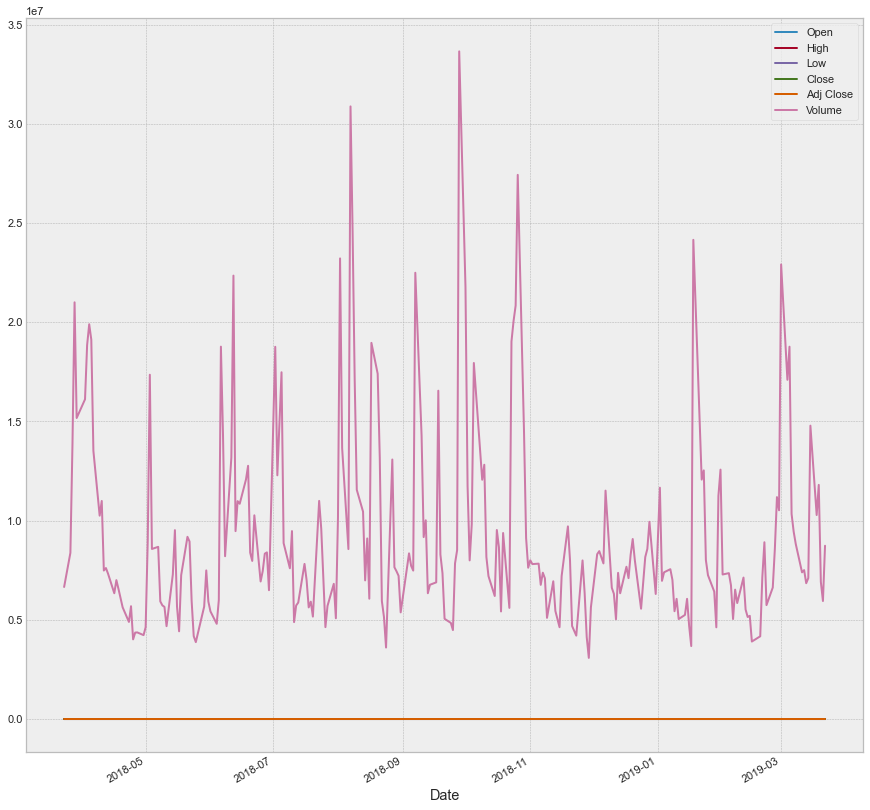

In [65]:
series = pd.read_csv("TSLA.csv")
series["Date"] = pd.to_datetime(series["Date"])
series.set_index("Date").plot()

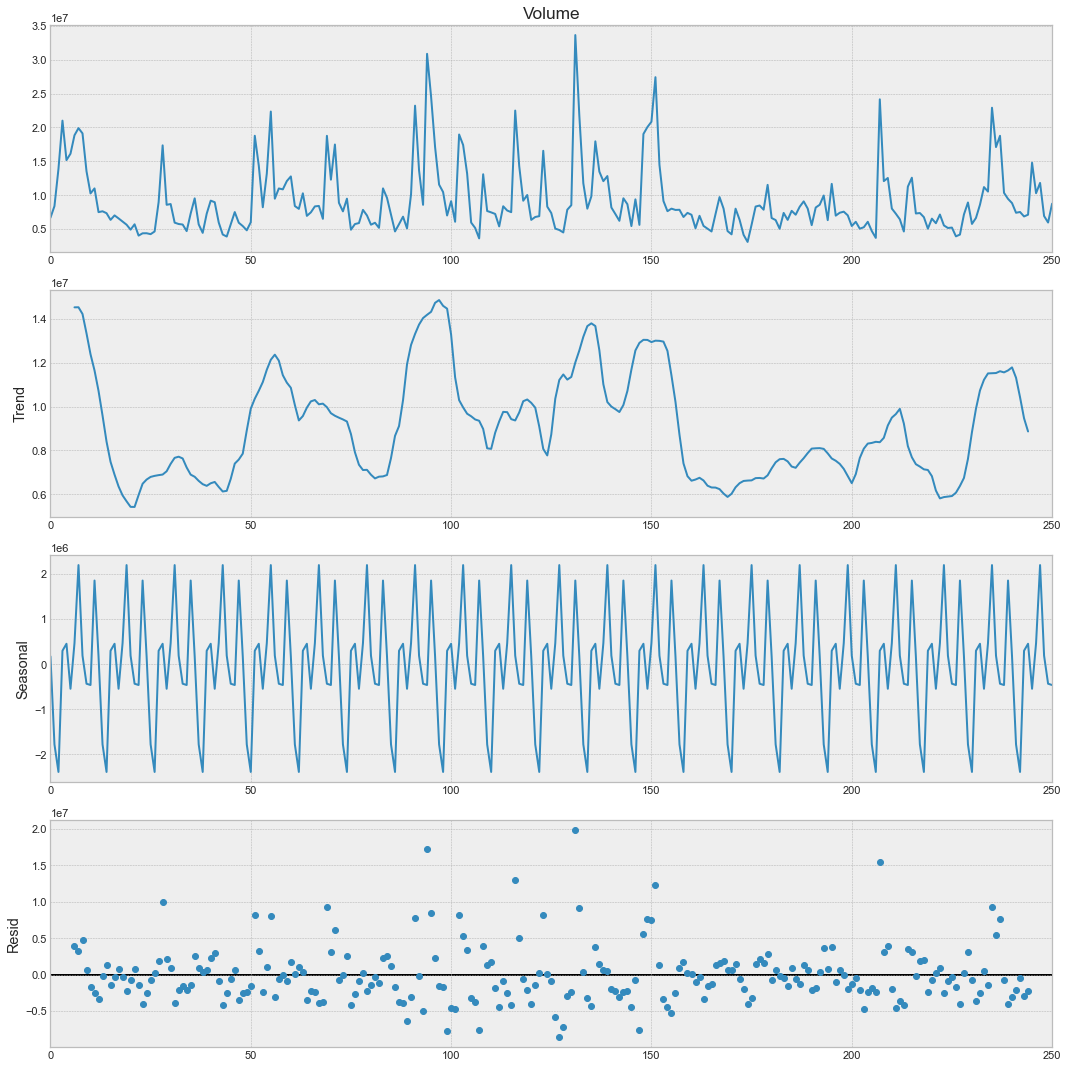

In [71]:
# decomposition
decomposition = sm.tsa.seasonal_decompose(series["Volume"], period=12)
figure = decomposition.plot()

plt.show()

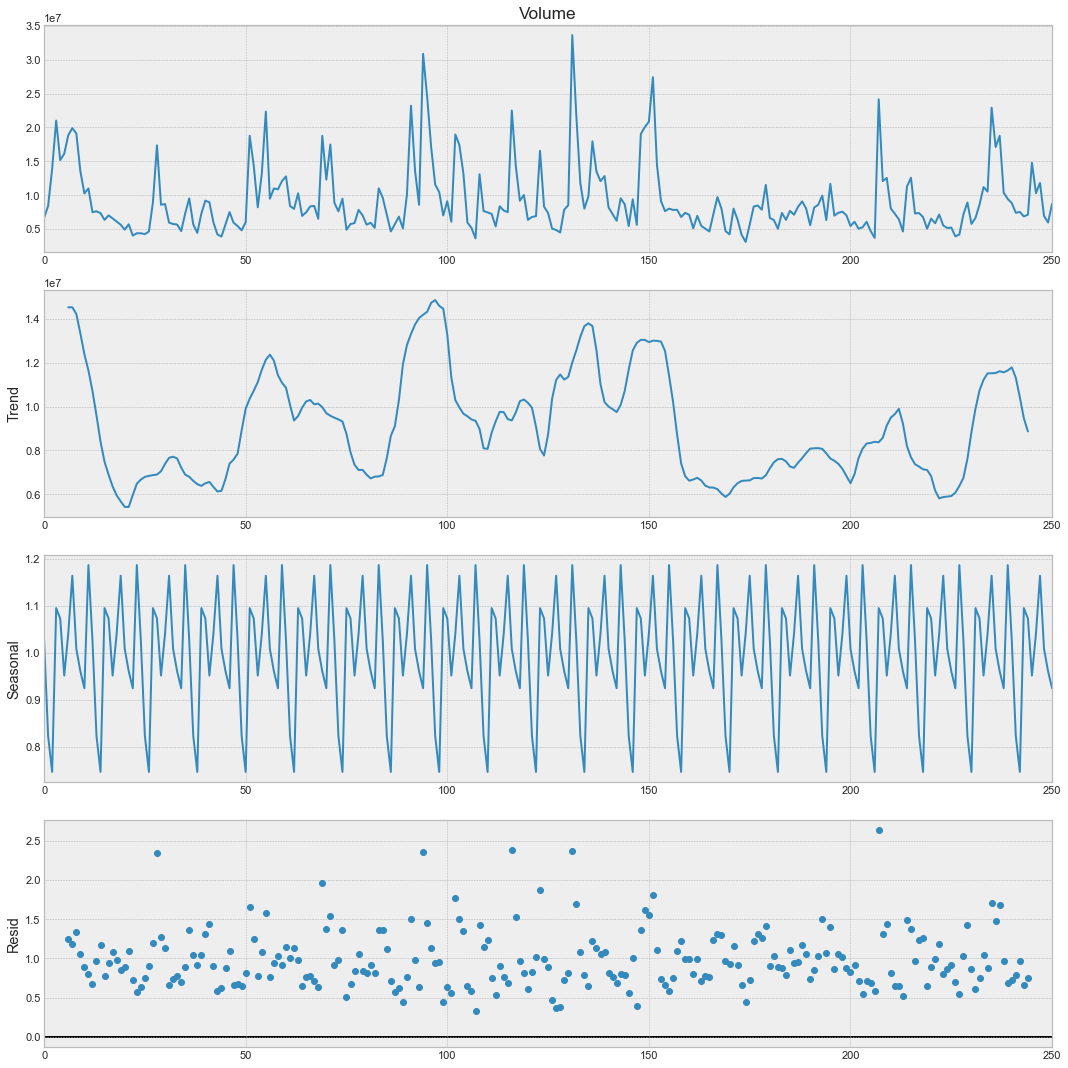

In [73]:
# Multiplicative


decomposition = sm.tsa.seasonal_decompose(
    series["Volume"], period=12, model="multiplicative"
)
figure = decomposition.plot()
plt.show()

# Meta's  Prophet 

<AxesSubplot:>

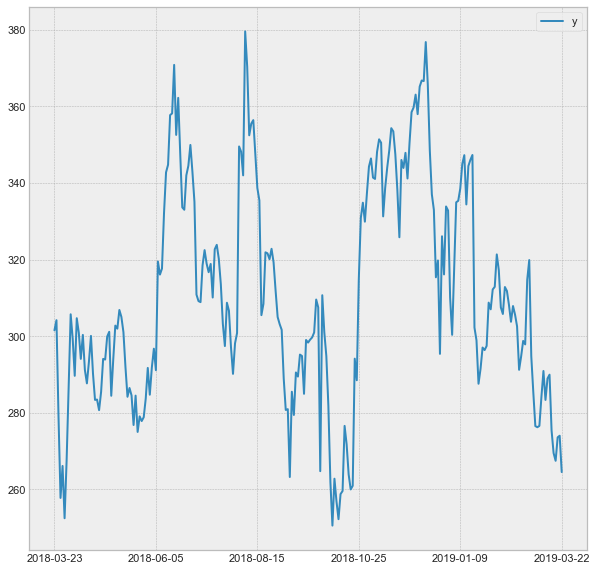

In [28]:
df = pd.read_csv("TSLA.csv")
df.head(10)


# Prophet does have a quirk: a hardcoded format for the input time series - it must consist of a date column named 'ds' (dataframe index or an actual column) and column 'y', where the actual values of the time series are stored
xdat = df[["Date", "Close"]].rename(columns={"Date": "ds", "Close": "y"})
xdat.set_index("ds").plot(figsize=(10, 10), xlabel="")

In [29]:
# automatic detection of changepoints
m = Prophet()
m.fit(xdat)

17:00:27 - cmdstanpy - INFO - Chain [1] start processing
17:00:27 - cmdstanpy - INFO - Chain [1] done processing


In [30]:
future = m.make_future_dataframe(periods=365)
future.tail()

ds
611 2020-03-17
612 2020-03-18
613 2020-03-19
614 2020-03-20
615 2020-03-21

In [31]:
forecast = m.predict(future)
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

ds   yhat  yhat_lower  yhat_upper
611 2020-03-17 119.15       12.85      213.86
612 2020-03-18 119.46       14.15      216.46
613 2020-03-19 119.10       16.23      219.55
614 2020-03-20 116.69       12.46      217.37
615 2020-03-21 125.76       17.35      221.65

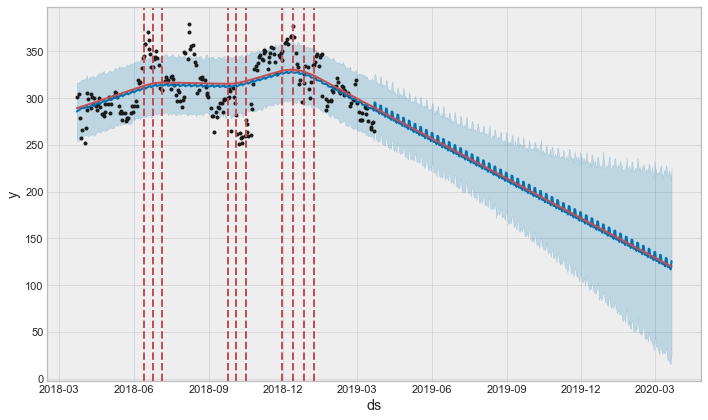

In [20]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

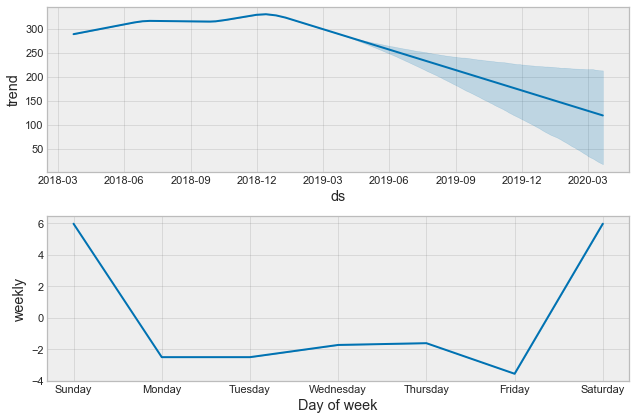

In [32]:
fig = m.plot_components(forecast)

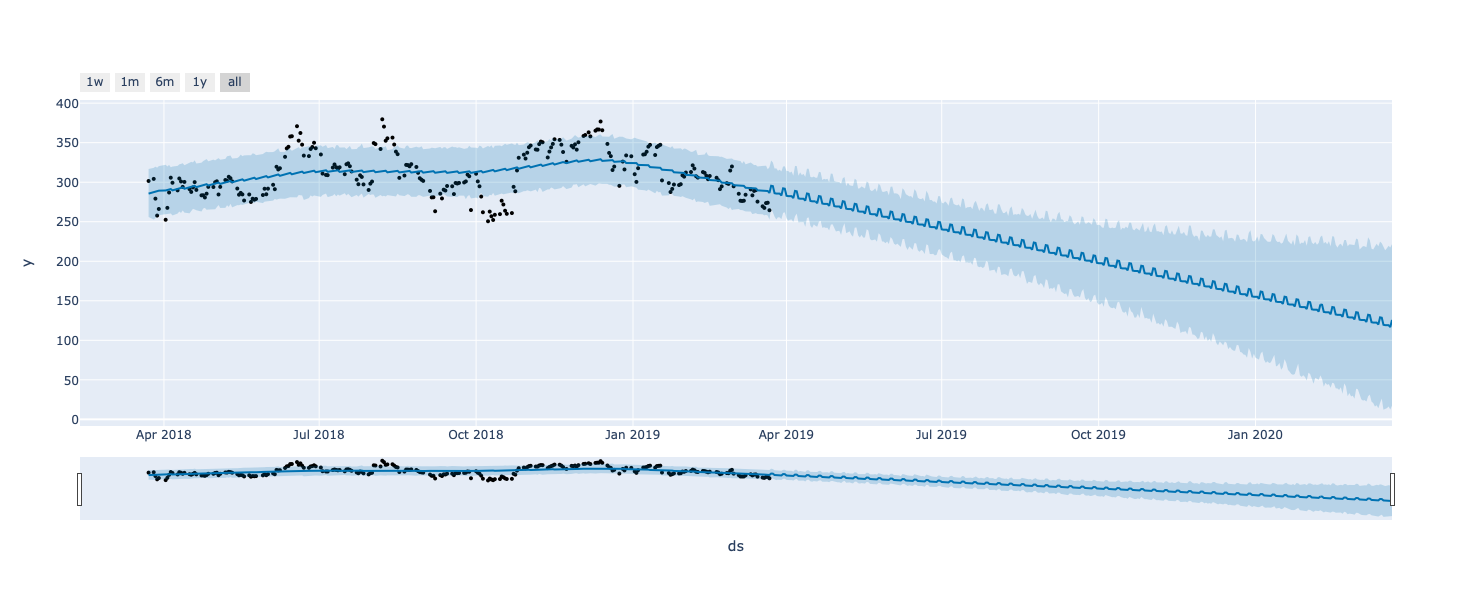

In [33]:
from prophet.plot import plot_components_plotly, plot_plotly

plot_plotly(m, forecast)

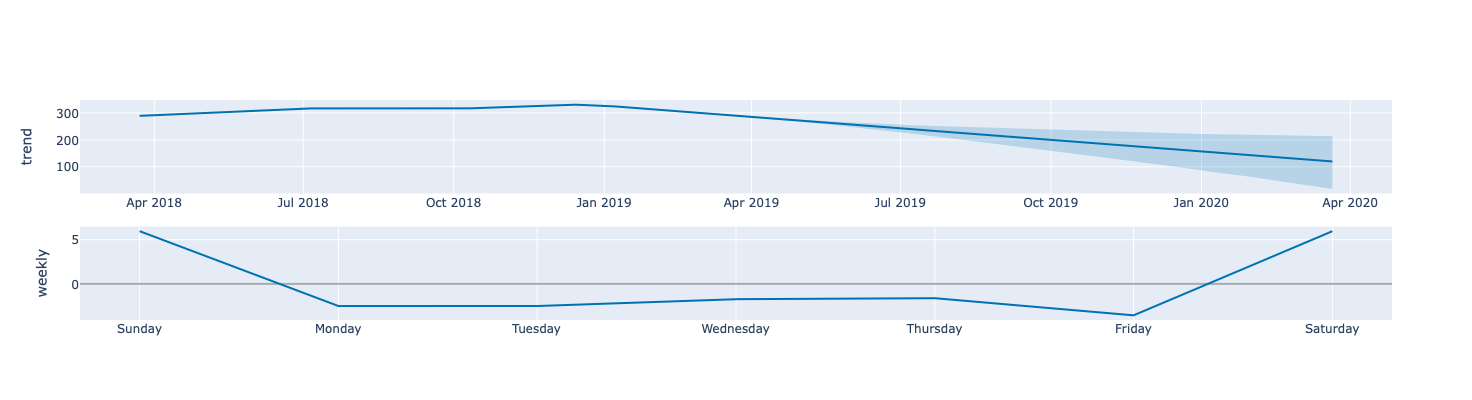

In [34]:
plot_components_plotly(m, forecast)

# Neural Networks with Metas Prophit 

<AxesSubplot:xlabel='ds'>

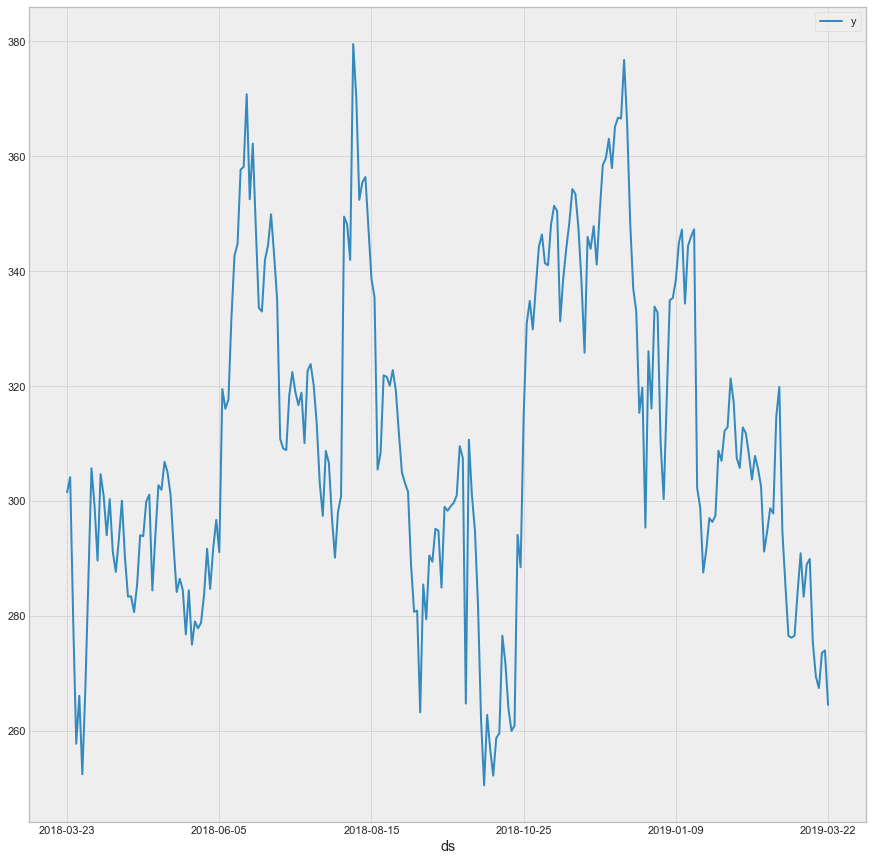

In [35]:
xdat.plot(x="ds", y="y")

In [36]:
df_train, df_valid = xdat.iloc[:-100], xdat.iloc[-264:]

In [37]:
df_train.head()

ds      y
0  2018-03-23 301.54
1  2018-03-26 304.18
2  2018-03-27 279.18
3  2018-03-28 257.78
4  2018-03-29 266.13

17:01:12 - cmdstanpy - INFO - Chain [1] start processing
17:01:12 - cmdstanpy - INFO - Chain [1] done processing


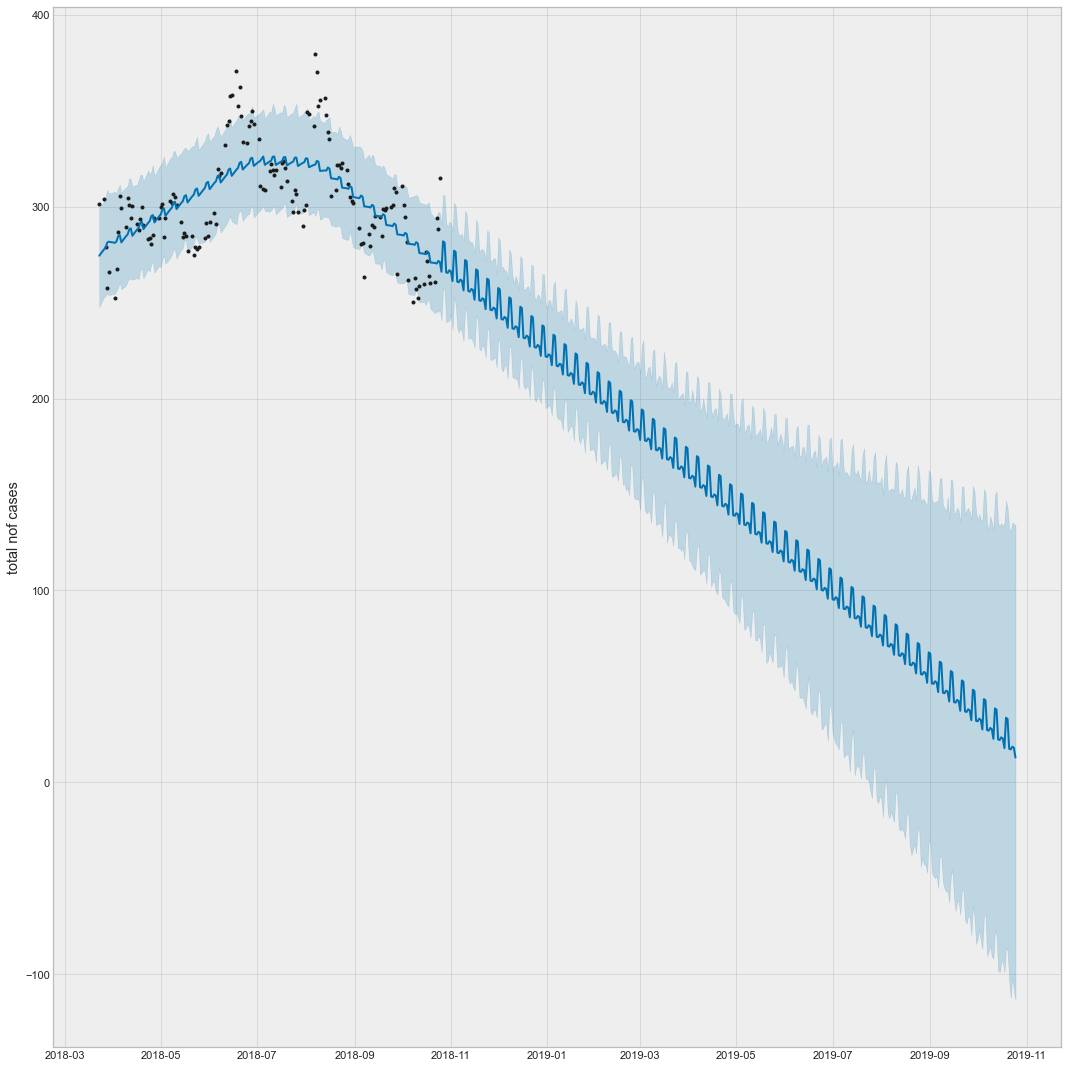

In [38]:
m_vanilla = Prophet()
m_vanilla.fit(df_train)

future = m_vanilla.make_future_dataframe(periods=365)
forecast_vanilla = m_vanilla.predict(future)

m_vanilla.plot(forecast_vanilla, figsize=(10, 10), xlabel="", ylabel="total nof cases")
print()

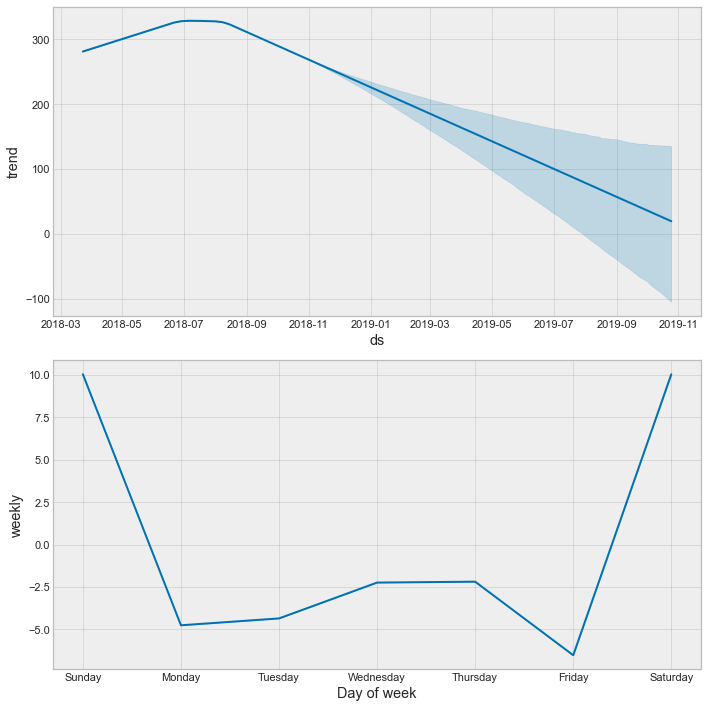

In [39]:
m_vanilla.plot_components(forecast_vanilla, figsize=(10, 10))
print()

In [41]:
from neuralprophet import NeuralProphet

pd.options.mode.chained_assignment = None


m_neural = NeuralProphet()

metrics = m_neural.fit(df_train, freq="B")

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.689% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 423


  0%|          | 0/109 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 5.62E-01


  0%|          | 0/109 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.25E-02, min: 2.15E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.38E-02
Epoch[423/423]: 100%|██████████| 423/423 [00:04<00:00, 85.26it/s, SmoothL1Loss=0.00874, MAE=11.1, RMSE=13.6, RegLoss=0]


INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.689% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 99.725% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 99.725% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B


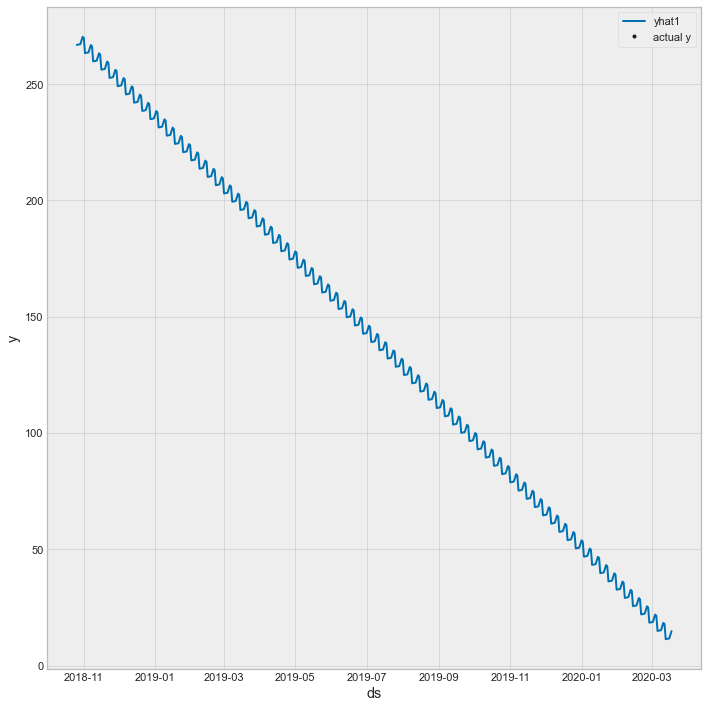

In [43]:
df_future = m_neural.make_future_dataframe(df_train, periods=364)
forecast_neural = m_neural.predict(df_future)
# create plots
fig_forecast = m_neural.plot(forecast_neural, figsize=(10, 10))

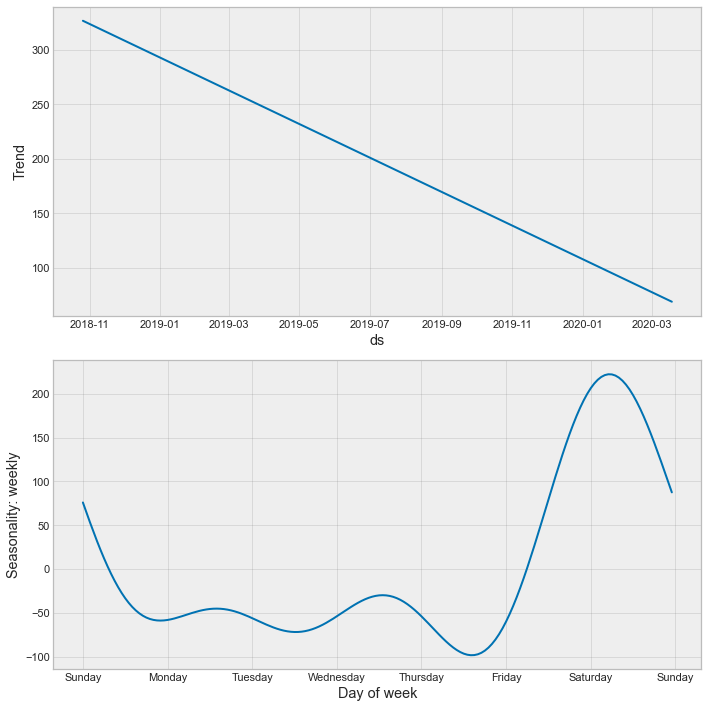

In [44]:
fig_components = m_neural.plot_components(forecast_neural, figsize=(10, 10))

In [45]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import median_absolute_error as mae


def my_mse(x, y):
    return np.round(np.sqrt(mse(x, y)), 2)


def my_mae(x, y):
    return np.round(np.sqrt(mae(x, y)), 2)

In [58]:
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 251 entries, 0 to 250
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ds                251 non-null    object 
 1   y                 251 non-null    float64
 2   forecast_vanilla  251 non-null    float64
dtypes: float64(2), object(1)
memory usage: 7.8+ KB


In [61]:
df_valid["forecast_vanilla"] = forecast_vanilla.yhat.tail(251).values
df_valid["forecast_neural"] = forecast_neural.yhat1.tail(251).values

In [62]:
df_valid.dropna(inplace=True)


err1 = my_mse(df_valid["y"], df_valid["forecast_vanilla"])
err2 = my_mse(df_valid["y"], df_valid["forecast_neural"])

print("MSE vanilla: " + str(err1))
print("MSE neural : " + str(err2))

err1 = my_mae(df_valid["y"], df_valid["forecast_vanilla"])
err2 = my_mae(df_valid["y"], df_valid["forecast_neural"])

print("   ")
print("MAE vanilla: " + str(err1))
print("MAE neural : " + str(err2))

MSE vanilla: 213.19
MSE neural : 218.32
   
MAE vanilla: 14.25
MAE neural : 14.31


###  As we can see clearly at this point and time the Neural network has done better 

 ----
 # Now we will Enter into financial time series  Territory 

In [65]:
import itertools
from random import gauss

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import probplot, shapiro
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch

plt.style.use("fivethirtyeight")

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [67]:
df = pd.read_csv("TSLA.csv")
df.head()

Date   Open   High    Low  Close  Adj Close    Volume
0  2018-03-23 311.25 311.25 300.45 301.54     301.54   6654900
1  2018-03-26 307.34 307.59 291.36 304.18     304.18   8375200
2  2018-03-27 304.00 304.27 277.18 279.18     279.18  13872000
3  2018-03-28 264.58 268.68 252.10 257.78     257.78  21001400
4  2018-03-29 256.49 270.96 248.21 266.13     266.13  15170700

In [70]:
df["Month"] = pd.DatetimeIndex(df["Date"]).month
df["Year"] = pd.DatetimeIndex(df["Date"]).year
group = df.groupby(["Month", "Year"])
df["VWAP"] = np.cumsum(df["Close"] * df["Volume"]) / np.cumsum(df["Volume"])

<AxesSubplot:xlabel='Date'>

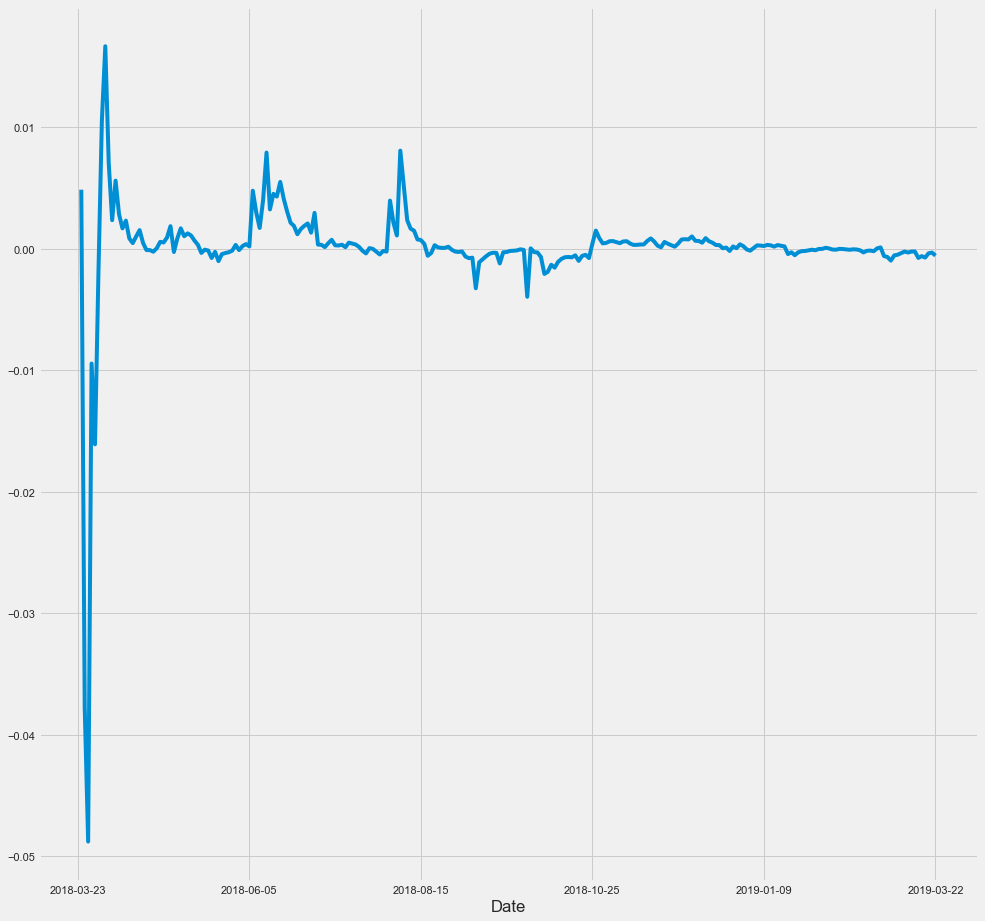

In [71]:
df.set_index("Date", drop=False, inplace=True)

df.VWAP.pct_change().plot()

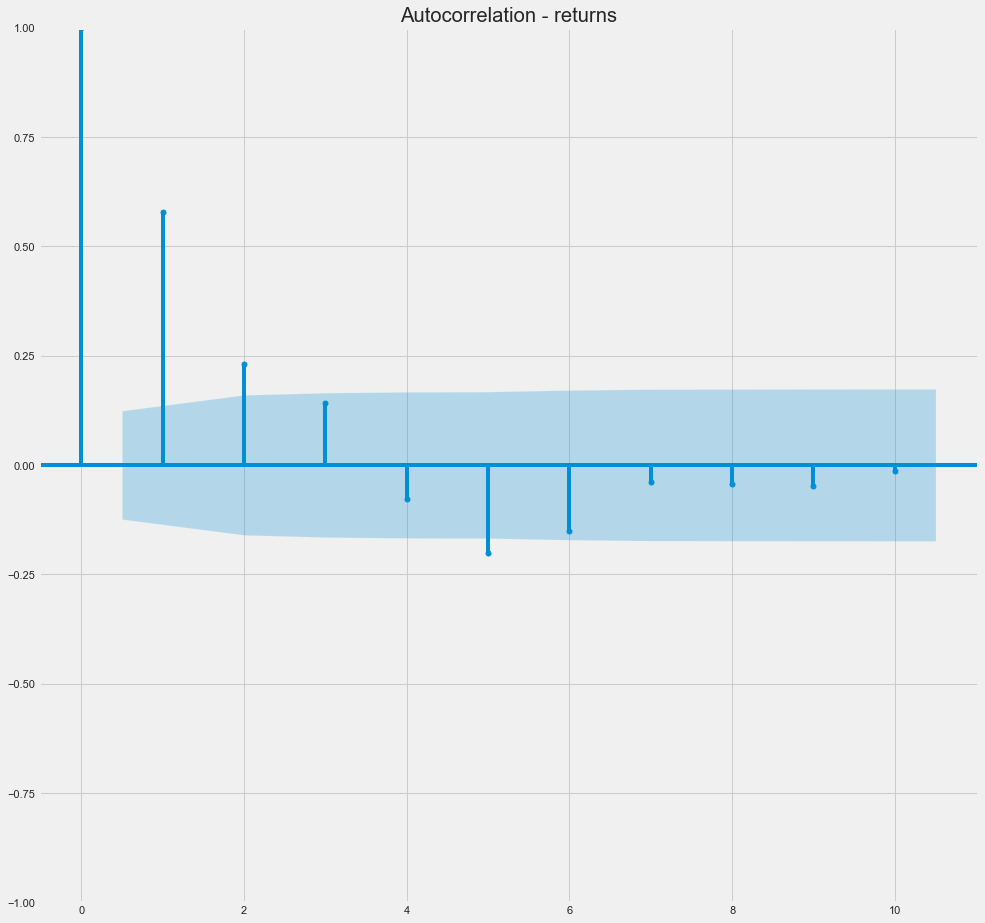

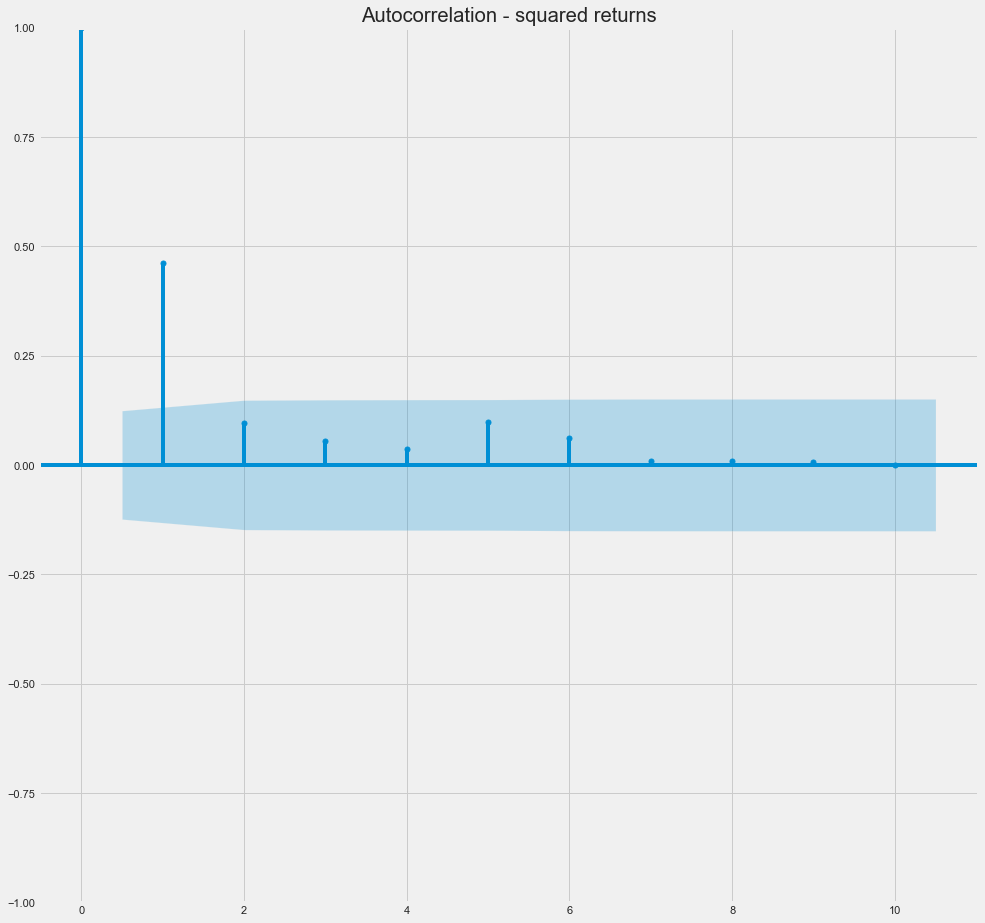

In [72]:
dfl = np.log1p(df.VWAP).diff().dropna()
plot_acf(dfl, lags=10, title="Autocorrelation - returns")
print()
plot_acf(dfl**2, lags=10, title="Autocorrelation - squared returns")
print()

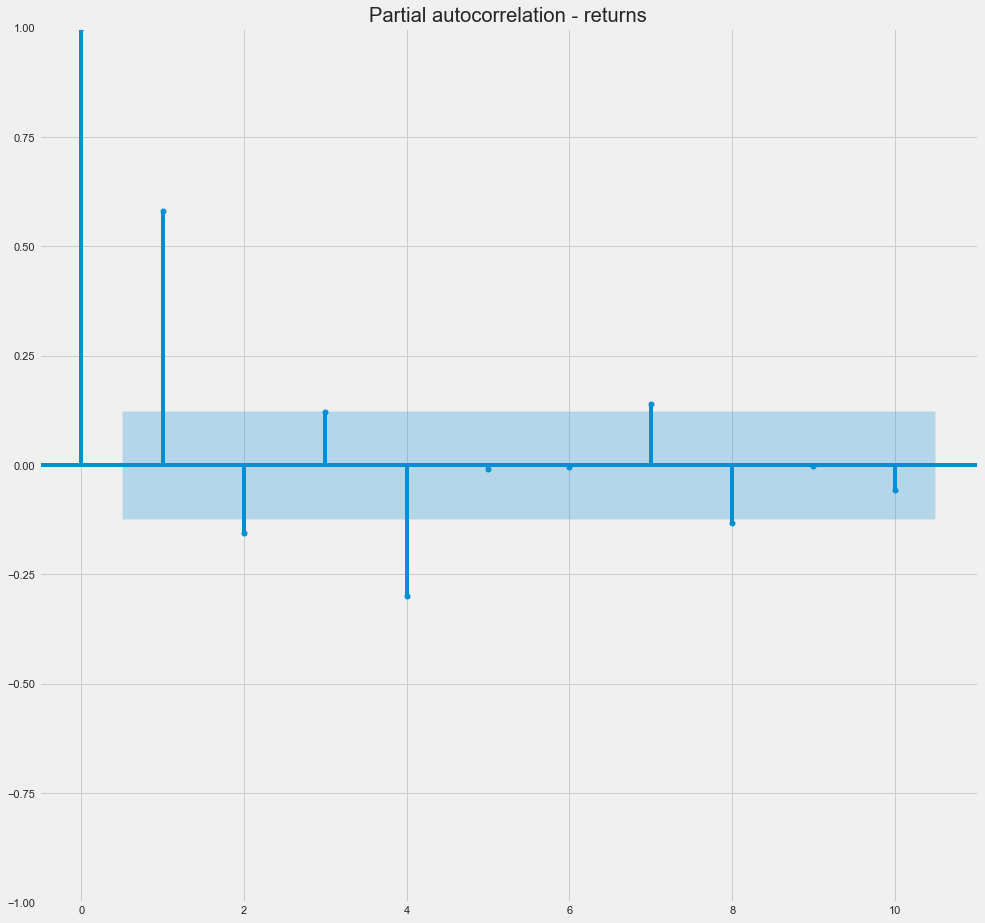

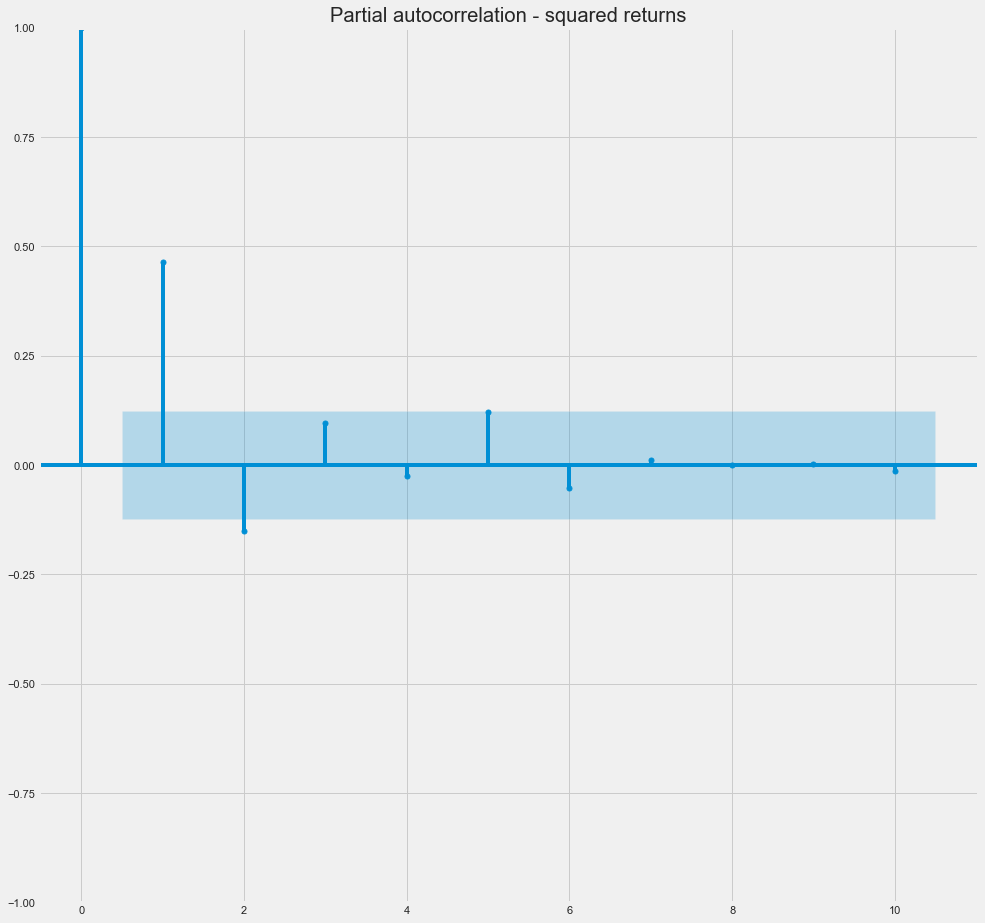

In [73]:
plot_pacf(dfl, lags=10, title="Partial autocorrelation - returns")
print()
plot_pacf(dfl**2, lags=10, title="Partial autocorrelation - squared returns")
print()

# ARCH
### A simplest model for time-varying variance is ARCH - the abbreviation stands for autoregressive conditional heteroskedasticity:


 . Unpacking:

AR(p) model: the current value (mean / expectation) of the series depends on p
  previous timesteps values
ARCH(p): the variance of the current time step is dependent on p
  lagged squared standard error terms. The standard error is the difference between the observed and predicted value from another model.estimated with OLS Lag range multiplier test
Let's see how we can go about this in practice:

In [74]:
from arch import arch_model

am = arch_model(100 * dfl, p=1, q=0)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     31,   Neg. LLF: 2484.402768385556
Iteration:     10,   Func. Count:     56,   Neg. LLF: -77.27746204453398
Iteration:     15,   Func. Count:     84,   Neg. LLF: 2156.841463618016
Iteration:     20,   Func. Count:    109,   Neg. LLF: -140.75050080343942
Iteration:     25,   Func. Count:    129,   Neg. LLF: -144.21206929202003
Optimization terminated successfully    (Exit mode 0)
            Current function value: -144.21207082124948
            Iterations: 29
            Function evaluations: 146
            Gradient evaluations: 27
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                   VWAP   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                144.212
Distribution:                  Normal   AIC:                          -282.424
Method:            Maximum L

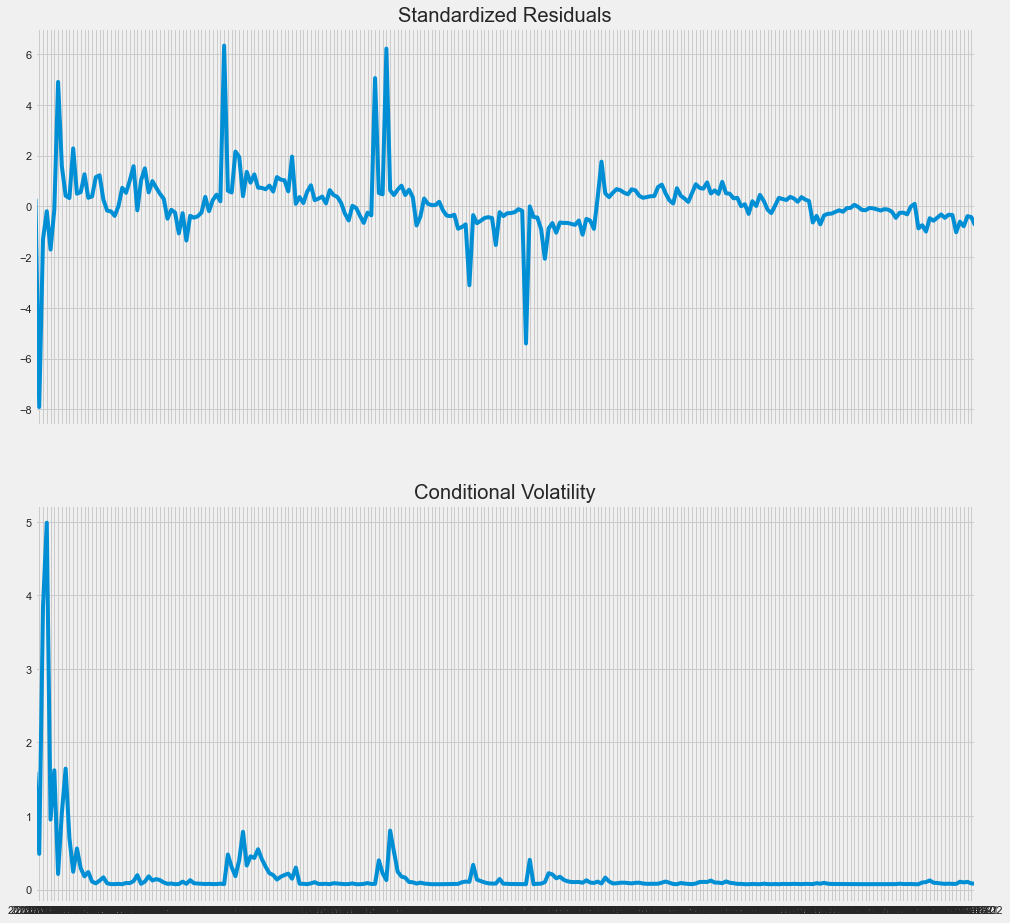

In [75]:
res.plot()
print()

# We can run some diagnostics on the model:

## Ljung-Box:
a test for autocorrelation (usable in tandem with ACF / PACF plots). H0 : The data is independently distributed, no autocorrelation, H1 : there is serial correlation.

## Engle ARCH: Ljung-Box and a Lagrange Multiplier test to determine if our ARCH model has captured the conditional heteroskedasticity
H^0 : the residuals are homoscedastic H1: squared residuals exhibit heteroskedasticity

In [76]:
max_lags = 5
residuals = res.resid
st_residuals = np.divide(res.resid, res.conditional_volatility)

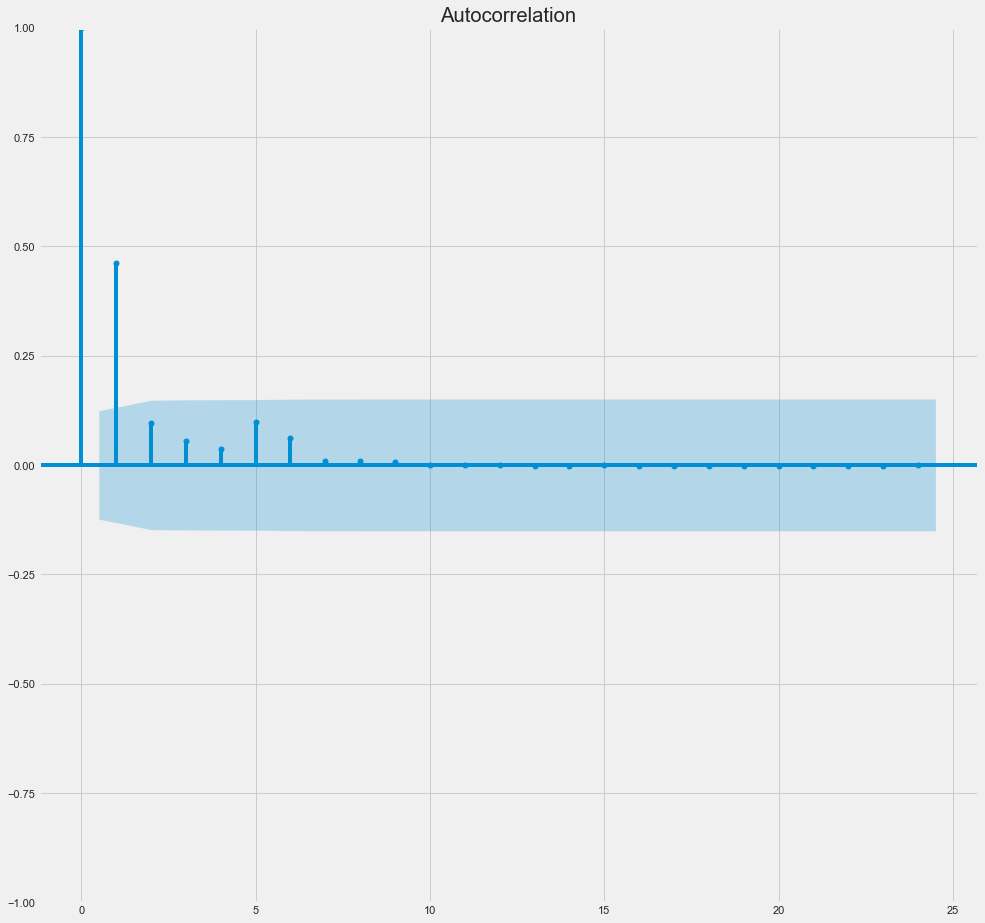

In [77]:
plot_acf(dfl**2)
print()

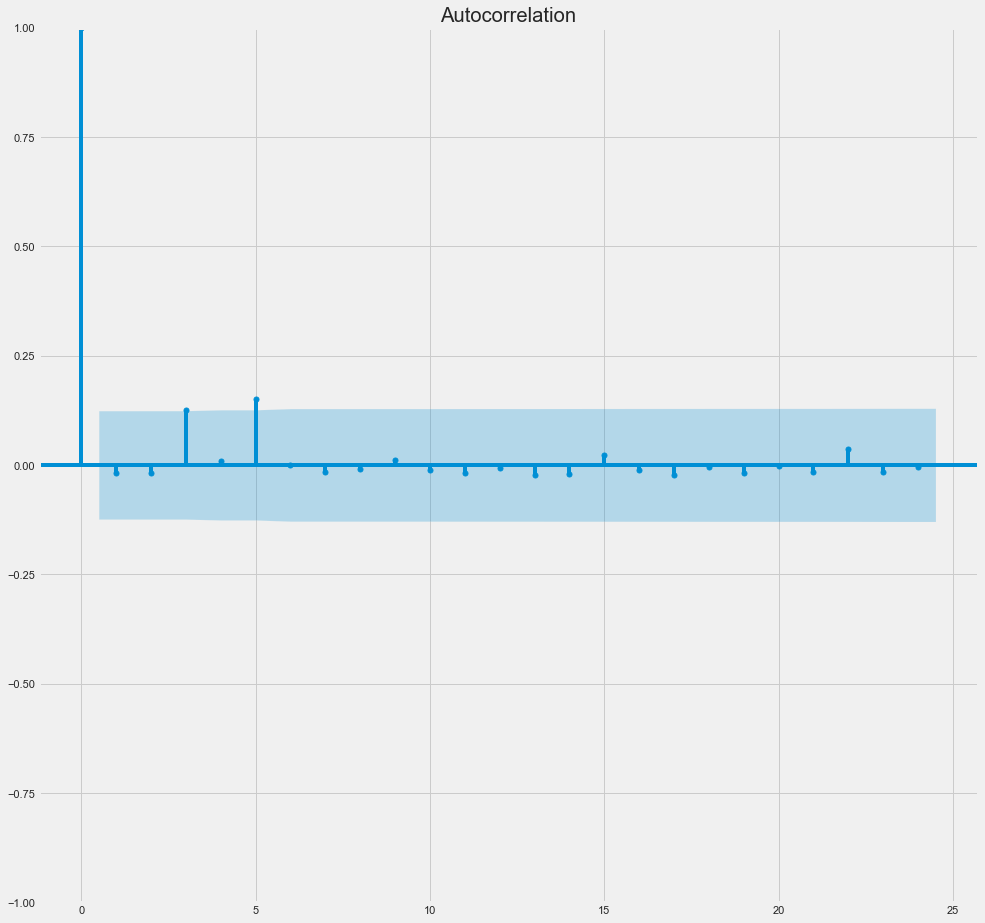

In [78]:
plot_acf(st_residuals**2)
print()

## Ljung-Box

In [ ]:
# why wont this work ???? 

In [96]:
etest = het_arch(dfl, maxlag=5)
print("pval Lagrange: " + str(np.round(etest[1], 4)))
print("pval F-test: " + str(np.round(etest[1], 4)))

pval Lagrange: 0.0
pval F-test: 0.0


In [101]:
etest = het_arch(st_residuals, maxlag=5)
print('pval Lagrange: ' + str(np.round(etest[1],4)))
print('pval F-test: ' + str(np.round(etest[1],4)))

pval Lagrange: 0.001
pval F-test: 0.001


# GARCH 

In [102]:
gm = arch_model(100 * dfl, p = 1, q = 1)
res = gm.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     33,   Neg. LLF: 375.0940726922042
Iteration:     10,   Func. Count:     63,   Neg. LLF: 12479.557524441081
Iteration:     15,   Func. Count:     91,   Neg. LLF: -185.14989034671402
Optimization terminated successfully    (Exit mode 0)
            Current function value: -185.14989034671402
            Iterations: 16
            Function evaluations: 95
            Gradient evaluations: 16
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   VWAP   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                185.150
Distribution:                  Normal   AIC:                          -362.300
Method:            Maximum Likelihood   BIC:                          -348.214
                                        No. Observations:                  250
Date:            

In [109]:
residuals = res.resid # Why wont this work // does tensor flow have something to do with it ?? 
st_residuals = np.divide(res.resid, res.conditional_volatility)
lb_test = acorr_ljungbox(dfl ** 2 , lags = max_lags)
for lag in range(max_lags):
    print('lag: ' + str(lag) + ' pval: ' + str(np.round(lb_test[1][lag], 4)))

KeyError: 1

In [105]:
etest = het_arch(dfl, maxlag=5)
print('pval Lagrange: ' + str(np.round(etest[1],4)))
print('pval F-test: ' + str(np.round(etest[1],4)))

pval Lagrange: 0.0
pval F-test: 0.0


In [106]:
etest = het_arch(st_residuals, maxlag=5)
print('pval Lagrange: ' + str(np.round(etest[1],4)))
print('pval F-test: ' + str(np.round(etest[1],4)))

pval Lagrange: 0.464
pval F-test: 0.464


Extensions
numerous extensions are possible to the basic GARCH
GJR - use asymmetric shock:

    


- we assumed constant mean so far - frequently not true
- combine ARIMA and GARCH: conditional mean  →→ conditional variance on residuals
                                               
- joint estimation > sequential - estimate consistency

In [113]:
from arch.univariate import ARX

ar = ARX(100 * dfl, lags=[1, 3])
print(ar.fit().summary())

                     AR - Constant Variance Model Results                     
Dep. Variable:                   VWAP   R-squared:                       0.373
Mean Model:                        AR   Adj. R-squared:                  0.368
Vol Model:          Constant Variance   Log-Likelihood:                74.9628
Distribution:                  Normal   AIC:                          -141.926
Method:            Maximum Likelihood   BIC:                          -127.888
                                        No. Observations:                  247
Date:                Tue, Jun 28 2022   Df Residuals:                      244
Time:                        19:11:13   Df Model:                            3
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
Const          0.0356  1.215e-02      2.934  3.349e-03 [1.

In [114]:
from arch.univariate import ARCH, GARCH

ar.volatility = GARCH(p=1, q = 1)
res = ar.fit(update_freq=0, disp="off")
print(res.summary())

                           AR - GARCH Model Results                           
Dep. Variable:                   VWAP   R-squared:                       0.149
Mean Model:                        AR   Adj. R-squared:                  0.142
Vol Model:                      GARCH   Log-Likelihood:                247.020
Distribution:                  Normal   AIC:                          -482.040
Method:            Maximum Likelihood   BIC:                          -460.984
                                        No. Observations:                  247
Date:                Tue, Jun 28 2022   Df Residuals:                      244
Time:                        19:14:16   Df Model:                            3
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const      3.2574e-03  5.767e-03      0.565      0.572 

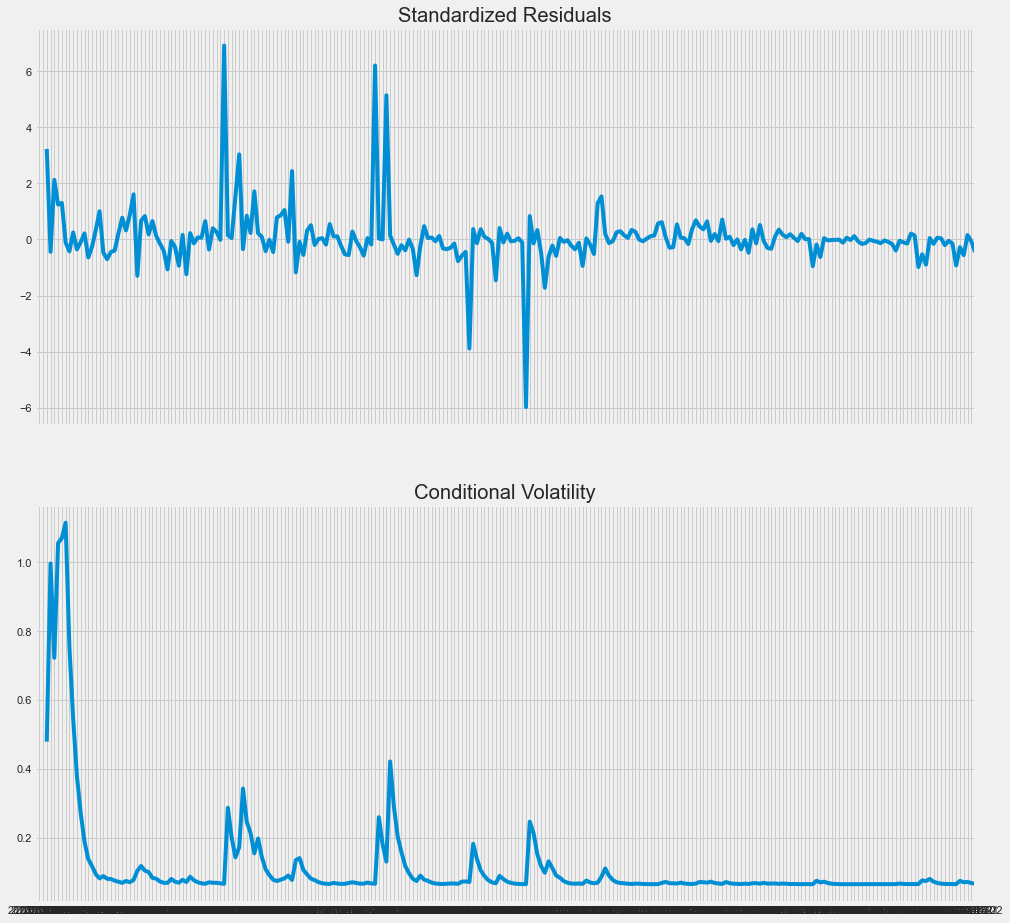

In [115]:
fig = res.plot()

# Forecasting
multi-step forecasts: recursion  →
→
  analytical form  ∼
∼
  linear in squared residual
simulation: parametric distribution
bootstrap: akin to simulation, but empirical residuals

In [116]:
dfl = np.log1p(df.VWAP).diff().dropna()
print(dfl.index.min(), dfl.index.max())

2018-03-26 2019-03-22
